<a href="https://colab.research.google.com/github/jmarrietar/ocular/blob/inceptionv3/Notebooks/transfer_learning_fine_tunning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
import itertools
import numpy as np
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mlxtend.plotting import plot_confusion_matrix 
%matplotlib inline

import tensorflow as tf
import keras
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications import InceptionV3 
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.layers import (
    Dense,
    GlobalAveragePooling2D,
    GlobalMaxPool1D,
    MaxPooling2D,
    Conv2D,
    BatchNormalization,
    Flatten,
    Dropout,
    Concatenate,
    Activation,
    Bidirectional,
)

from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.models import Model, Sequential, model_from_json
from keras_preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [ ]:
"""
from IPython.display import clear_output
clear_output()
"""

In [ ]:
#!gdown https://drive.google.com/uc?id=1ysmhUNNwFoGr23F_YbVbbBCziPCfIUS3

In [ ]:
#!gdown https://drive.google.com/uc?id=1AnsT5cPD86Iza_bxCQhvqhYz5LAQM_WK

In [2]:
!gdown https://drive.google.com/uc?id=178vQcxTIS5qlzoXjNSqF5qJ-UiqZEm1v

Downloading...
From: https://drive.google.com/uc?id=178vQcxTIS5qlzoXjNSqF5qJ-UiqZEm1v
To: /content/kaggle_train.zip
1.90GB [00:14, 128MB/s]


In [3]:
!gdown https://drive.google.com/uc?id=1Fij91Xl0KV0d3hx3sDnzqEwoZQGKs21L

Downloading...
From: https://drive.google.com/uc?id=1Fij91Xl0KV0d3hx3sDnzqEwoZQGKs21L
To: /content/messidor2_processed.zip
107MB [00:00, 139MB/s]  


In [4]:
!gdown https://drive.google.com/uc?id=1pQJSkYChZp8zWmLx05B_4L26O-bPonZi

Downloading...
From: https://drive.google.com/uc?id=1pQJSkYChZp8zWmLx05B_4L26O-bPonZi
To: /content/kaggle_test.zip
2.90GB [00:55, 51.8MB/s]


In [5]:
#local_zip = '/content/kaggle_sample.zip'
local_zip = '/content/kaggle_train.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [6]:
#local_zip = '/content/kaggle_sample.zip'
local_zip = '/content/kaggle_test.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [7]:
#local_zip = '/content/Messidor-2.zip'
local_zip = '/content/messidor2_processed.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [8]:
# Train data 
train_dir_1 = os.path.join('/content/kaggle_train/train/processed/1')
train_dir_0 = os.path.join('/content/kaggle_train/train/processed/0')

print("Total imagenes training Diabetic Retinopathy:", len(os.listdir(train_dir_1)))
print(
    "Total imagenes training Non Diabetic Retinopathy:",
    len(os.listdir(train_dir_0)),
)

Total imagenes training Diabetic Retinopathy: 9313
Total imagenes training Non Diabetic Retinopathy: 25808


In [12]:
# Test data 
test_dir_1 = os.path.join('/content/kaggle_test/processed/1')
test_dir_0 = os.path.join('/content/kaggle_test/processed/0')

print("Total imagenes Test Diabetic Retinopathy:", len(os.listdir(test_dir_1)))
print(
    "Total imagenes Test Non Diabetic Retinopathy:",
    len(os.listdir(test_dir_0)),
)

Total imagenes Test Diabetic Retinopathy: 14042
Total imagenes Test Non Diabetic Retinopathy: 39529


In [9]:
dr_files = os.listdir(train_dir_1)
no_dr_files = os.listdir(train_dir_0)

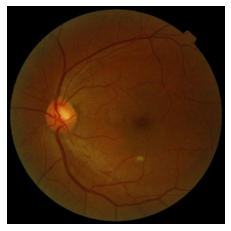

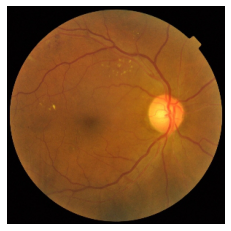

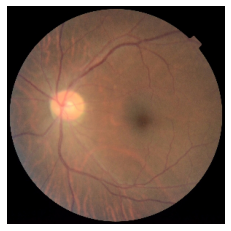

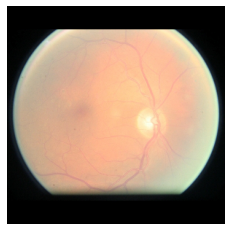

In [11]:
pic_index = 2

next_dr = [os.path.join(train_dir_1, fname) for fname in dr_files[pic_index - 2 : pic_index]]
next_no_dr = [
    os.path.join(train_dir_0, fname) for fname in no_dr_files[pic_index - 2 : pic_index]
]

for i, img_path in enumerate(next_dr + next_no_dr):

    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.axis("Off")
    plt.show()

In [12]:
TRAINING_DIR = "/content/kaggle_train/train/processed"
TEST_DIR = "/content/kaggle_test/processed"
TEST_MESSIDOR_DIR = "/content/messidor2_processed"

BATCH_SIZE = 32
img_width, img_height = 299, 299

training_datagen = ImageDataGenerator(
    rescale=1.0 / 255, # Paper de Augmentation 
)

train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(img_width, img_height),
    class_mode="binary",
    batch_size=BATCH_SIZE,
    shuffle=True,
)

Found 35121 images belonging to 2 classes.


In [13]:
# Added class weigths 
from sklearn.utils import class_weight
y_train = train_generator.classes
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
class_weights = dict(enumerate(class_weights))

In [14]:
training_datagen2 = ImageDataGenerator(
    rescale=1.0 / 255
)

train_generator2 = training_datagen2.flow_from_directory(
    TRAINING_DIR,
    target_size=(img_width, img_height),
    class_mode="binary",
    batch_size=1,
    shuffle=False,
)

Found 35121 images belonging to 2 classes.


In [15]:
test_datagen = ImageDataGenerator(rescale=1/255)

test_generator = test_datagen.flow_from_directory(
	TEST_DIR,
    target_size=(img_width, img_height),
	class_mode='binary', 
    batch_size=1,
    shuffle=False,
)

Found 53571 images belonging to 2 classes.


In [16]:
messidor_datagen = ImageDataGenerator(rescale=1/255)

messidor_generator = messidor_datagen.flow_from_directory(
	TEST_MESSIDOR_DIR,
    target_size=(img_width, img_height),
	class_mode='binary', 
    batch_size=1,
    shuffle=False,
)

Found 1748 images belonging to 2 classes.


In [17]:
steps_per_epoch = train_generator.n // BATCH_SIZE
#validation_steps = img_iter_dev.n // BATCH_SIZE

In [18]:
train_generator.n

35121

In [19]:
BATCH_SIZE

32

In [20]:
steps_per_epoch

1097

## 1.2 Fine tunning 

#### Warmup
First we do a warmup training only the top layers:

In [22]:
base_model = InceptionV3(weights='imagenet', 
                   include_top=False,
                   pooling='avg',
                   input_shape=(img_width, img_height,3))

# Freeze the feature extractor
for layer in base_model.layers:
    layer.trainable=False

x1 = Dense(2048, activation='relu')(base_model.output)
predictions = Dense(1, activation='sigmoid')(x1)

visual_model = Model(inputs=base_model.input, outputs=predictions)

visual_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-6,
                                       decay=4e-5),
    metrics=['accuracy', tf.keras.metrics.AUC()]
)

visual_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 149, 149, 32) 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 149, 149, 32) 0           batch_normalization_95[0][0]     
____________________________________________________________________________________________

In [23]:
visual_model.fit_generator(
    train_generator,
    epochs=40,
    class_weight=class_weights,
    steps_per_epoch=steps_per_epoch
)

Epoch 1/40
1097/1097 [==============================] - 174s 158ms/step - loss: 0.6898 - accuracy: 0.6095 - auc: 0.5993
Epoch 2/40
1097/1097 [==============================] - 136s 124ms/step - loss: 0.6398 - accuracy: 0.6581 - auc: 0.6453
Epoch 3/40
1097/1097 [==============================] - 136s 124ms/step - loss: 0.6290 - accuracy: 0.6732 - auc: 0.6623
Epoch 4/40
1097/1097 [==============================] - 136s 124ms/step - loss: 0.6197 - accuracy: 0.6829 - auc: 0.6735
Epoch 5/40
1097/1097 [==============================] - 137s 125ms/step - loss: 0.6141 - accuracy: 0.6814 - auc: 0.6819
Epoch 6/40
1097/1097 [==============================] - 140s 128ms/step - loss: 0.6096 - accuracy: 0.6863 - auc: 0.6889
Epoch 7/40
1097/1097 [==============================] - 138s 126ms/step - loss: 0.6070 - accuracy: 0.6888 - auc: 0.6941
Epoch 8/40
1097/1097 [==============================] - 137s 125ms/step - loss: 0.6031 - accuracy: 0.6934 - auc: 0.6986
Epoch 9/40
1097/1097 [==================

#### Unfreeze the extractor layers:
- Allow some of the layers to train with a reduced learning rate  

In [25]:
for layer in visual_model.layers:
    layer.trainable = True

# change the learning rate
visual_model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-6,
                                       decay=4e-5),
    metrics=['accuracy', tf.keras.metrics.AUC()]
)

train_generator.reset()

# train
history = visual_model.fit_generator(
    train_generator,
    epochs=50,
    steps_per_epoch=steps_per_epoch
    )

Epoch 1/50
1097/1097 [==============================] - 476s 434ms/step - loss: 0.3970 - accuracy: 0.8244 - auc_2: 0.8595
Epoch 2/50
1097/1097 [==============================] - 459s 418ms/step - loss: 0.3698 - accuracy: 0.8388 - auc_2: 0.8638
Epoch 3/50
1097/1097 [==============================] - 459s 418ms/step - loss: 0.3482 - accuracy: 0.8486 - auc_2: 0.8715
Epoch 4/50
1097/1097 [==============================] - 458s 418ms/step - loss: 0.3321 - accuracy: 0.8574 - auc_2: 0.8784
Epoch 5/50
1097/1097 [==============================] - 458s 418ms/step - loss: 0.3151 - accuracy: 0.8673 - auc_2: 0.8854
Epoch 6/50
1097/1097 [==============================] - 458s 418ms/step - loss: 0.3017 - accuracy: 0.8728 - auc_2: 0.8918
Epoch 7/50
1097/1097 [==============================] - 458s 417ms/step - loss: 0.2862 - accuracy: 0.8840 - auc_2: 0.8977
Epoch 8/50
1097/1097 [==============================] - 457s 417ms/step - loss: 0.2763 - accuracy: 0.8866 - auc_2: 0.9030
Epoch 9/50
1097/1097 [==

----------

#### Metrics on Kaggle train

In [26]:
train_generator2.reset()
threshold = 0.5
img_iter_val_0, img_iter_val_1 = itertools.tee(train_generator2, 2)
y_true = train_generator2.classes
y_pred_prob_visual = visual_model.predict(train_generator2,verbose=1,workers=0)
y_pred_prob_visual = np.hstack(y_pred_prob_visual)
y_pred = (y_pred_prob_visual> threshold).astype('int')

35121/35121 [==============================] - 962s 27ms/step


In [27]:
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred_prob_visual, pos_label=1)
cm=metrics.confusion_matrix(y_true, y_pred)
print('Accuracy: {}'.format(accuracy_score(y_true, y_pred)))
auc = roc_auc_score(y_true, y_pred_prob_visual)
print('AUC: {}'.format(roc_auc_score(y_true, y_pred_prob_visual)))

Accuracy: 0.9983200933914183
AUC: 0.9999985063443171


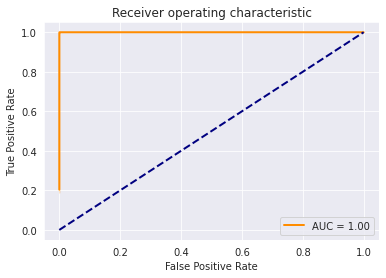

In [28]:
lw = 2
sns.set_style({'axes.grid' : False})
sns.set_style("darkgrid")
ax = sns.lineplot(fpr, tpr, color='darkorange',
         lw=lw, label='AUC = %0.2f' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
ax.set_title('Receiver operating characteristic')
ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
plt.legend(loc="lower right")
plt.show()

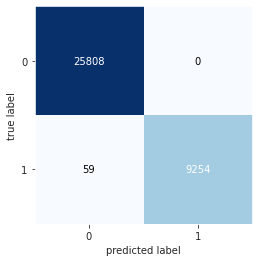

In [29]:
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_normed=False)
plt.show()

#### Metrics on Kaggle test

In [30]:
threshold = 0.5
img_iter_val_0, img_iter_val_1 = itertools.tee(test_generator, 2)
y_true = test_generator.classes

y_pred_prob_visual = visual_model.predict_generator(test_generator, verbose=1, workers=5)
y_pred_prob_visual = np.hstack(y_pred_prob_visual)
y_pred = (y_pred_prob_visual> threshold).astype('int')

53571/53571 [==============================] - 1410s 26ms/step


In [31]:
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred_prob_visual, pos_label=1)
cm=metrics.confusion_matrix(y_true, y_pred)
print('Accuracy: {}'.format(accuracy_score(y_true, y_pred)))
auc = roc_auc_score(y_true, y_pred_prob_visual)
print('AUC: %.3f' % auc)

Accuracy: 0.756827387952437
AUC: 0.702


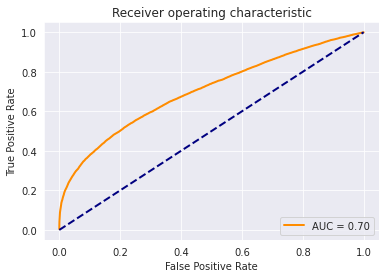

In [32]:
lw = 2
sns.set_style({'axes.grid' : False})
sns.set_style("darkgrid")
ax = sns.lineplot(fpr, tpr, color='darkorange',
         lw=lw, label='AUC = %0.2f' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
ax.set_title('Receiver operating characteristic')
ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
plt.legend(loc="lower right")
plt.show()

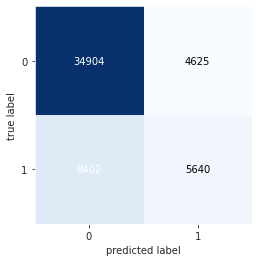

In [33]:
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_normed=False)
plt.show()

#### Metrics on Messidor-2

In [34]:
threshold = 0.5
img_iter_val_0, img_iter_val_1 = itertools.tee(messidor_generator, 2)
y_true = messidor_generator.classes

In [35]:
y_pred_prob_visual = visual_model.predict_generator(messidor_generator, verbose=1, workers=5)
y_pred_prob_visual = np.hstack(y_pred_prob_visual)
y_pred = (y_pred_prob_visual> threshold).astype('int')

1748/1748 [==============================] - 46s 26ms/step


In [36]:
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred_prob_visual, pos_label=1)
cm=metrics.confusion_matrix(y_true, y_pred)
print('Accuracy: {}'.format(accuracy_score(y_true, y_pred)))
auc = roc_auc_score(y_true, y_pred_prob_visual)
print('AUC: %.3f' % auc)

Accuracy: 0.6458810068649885
AUC: 0.644


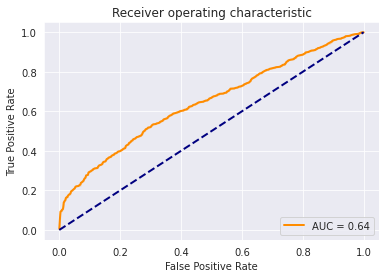

In [37]:
lw = 2
sns.set_style({'axes.grid' : False})
sns.set_style("darkgrid")
ax = sns.lineplot(fpr, tpr, color='darkorange',
         lw=lw, label='AUC = %0.2f' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
ax.set_title('Receiver operating characteristic')
ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
plt.legend(loc="lower right")
plt.show()

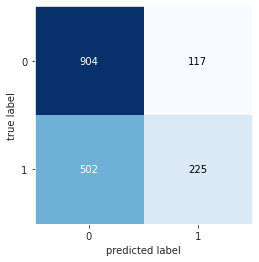

In [38]:
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_normed=False)
plt.show()